# Black-Scholes model study

Let us introduce the Black-Scholes model : 

$dS_t = rS_t dt + \sigma S_t dW_t $

Given the **Euler-Maruyama Approximation** :

$S_{t+\Delta t} =S_t + r S_t dt + \sigma S_t \sqrt{dt} Z$

With $Z \sim \mathcal{N}(0,1)$

Let us code this model via Python :

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sk

In [3]:
S0 = 1000
r = .08
sigma = .4
T = 1
N = 365
M = 100
dt = T/N

S = np.zeros((M, N+1))
S[:,0]=S0

for t in range(1, N+1):
    Z = np.random.standard_normal(M)
    S[:, t] = S[:, t-1] + r * S[:, t-1]*dt + sigma * S[:, t-1] * np.sqrt(dt) * Z

In [4]:
ST = S[:, -1]
K = 1000

call_price= np.exp(-r*T)*np.mean(np.maximum(ST-K, 0))
put_price = np.exp(-r*T)*np.mean(np.maximum(K-ST, 0))
diff = call_price - put_price
print(f"Simulated European Call price : {call_price}")
print(f"Simulated European Put price : {put_price}")
print(f"Call-Put difference : {diff} ")

Simulated European Call price : 216.88927646962478
Simulated European Put price : 99.58661582147838
Call-Put difference : 117.3026606481464 


## Visualization of 100 simulated paths using the Black-Scholes model 

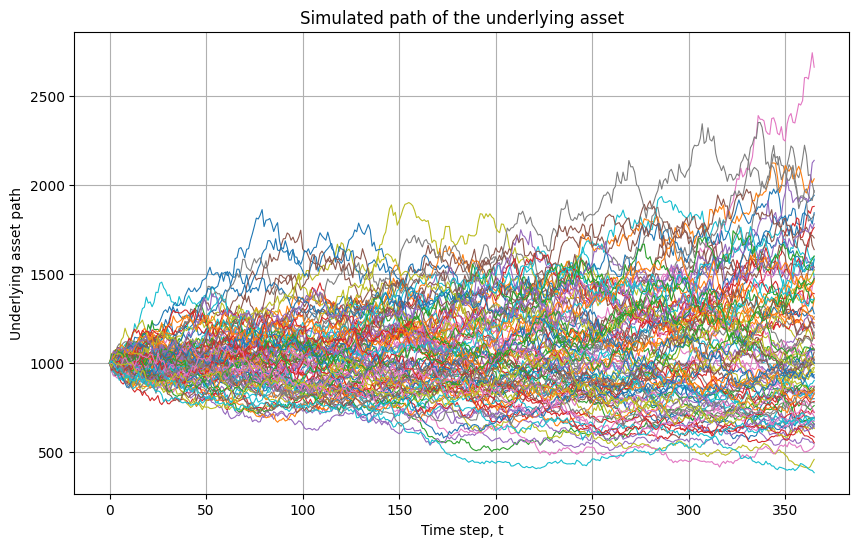

In [5]:
plt.figure(figsize=(10,6))
for i in range(M):
    plt.plot(S[i], lw = 0.8)
plt.title("Simulated path of the underlying asset")
plt.xlabel("Time step, t")
plt.ylabel("Underlying asset path")
plt.grid(True)
plt.show()

Let us visualize the **average of all simulated paths**

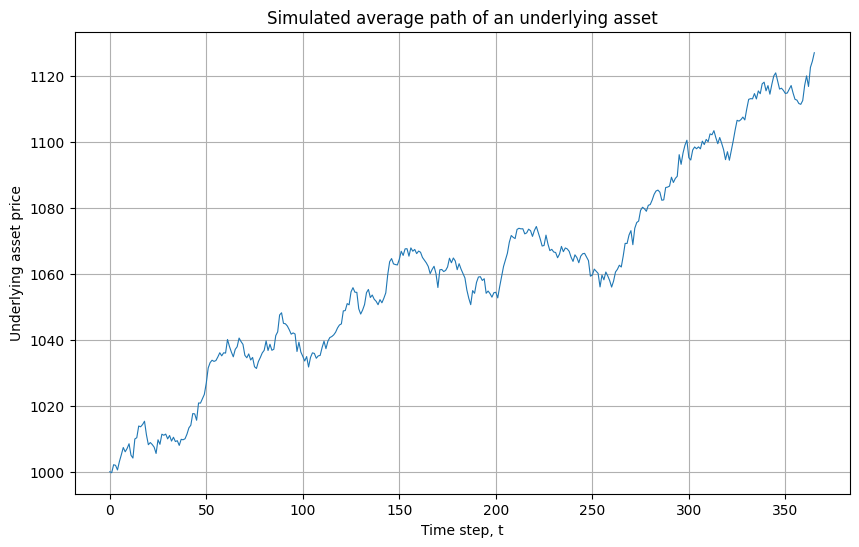

In [6]:
plt.figure(figsize=(10,6))
plt.plot(np.mean(S, axis=0), lw = 0.8)
plt.title("Simulated average path of an underlying asset")
plt.xlabel("Time step, t")
plt.ylabel("Underlying asset price")
plt.grid(True)
plt.show()

## Visualization of call and put option prices as functions of volatility ($\sigma$), time to maturity ($T$), and the risk-free interest rate ($r$).

The analytical price of a European call/put is :

Defining $d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}}$ et $d_2 = d_1 - \sigma \sqrt{T}$

$C(S_0, K, T, r, \sigma)= S_0\Phi(d_1) - Ke^{-rT}\Phi(d_2)$, $\Phi$ - cumulative function of a normal standard distribution

$P(S_0, K, T, r, \sigma) = Ke^{-rT}\Phi(-d_2) - S_0\Phi(-d_1)$

### Let’s visualize the option prices as a function of volatility ($\sigma$).

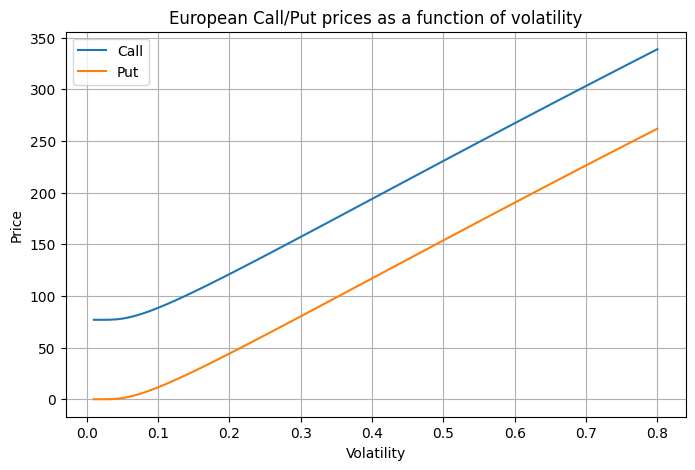

In [7]:
def b_s_call(Sc,Kc,Tc,rc,sc):
    d1=(np.log(Sc/Kc) + (rc + 0.5 * sc**2)*Tc)/ (sc * np.sqrt(Tc))
    d2 = d1 - sc*np.sqrt(Tc)
    return Sc*sk.norm.cdf(d1) - Kc* np.exp(-rc*Tc) * sk.norm.cdf(d2)

def b_s_put(Sp,Kp,Tp,rp,sp):
    d1=(np.log(Sp/Kp) + (rp + 0.5 * sp**2)*Tp)/ (sp* np.sqrt(Tp))
    d2 = d1 - sp*np.sqrt(Tp)
    return -Sp*sk.norm.cdf(-d1) + Kp * np.exp(-rp*Tp) * sk.norm.cdf(-d2)

s= np.linspace(0.01, 0.8, 100)
S0 = 1000
r = .08
T = 1
K=1000

call_prices_sigma = [b_s_call(S0, K, T, r, sc) for sc in s ]
put_prices_sigma = [b_s_put(S0, K, T, r, sp) for sp in s ]

plt.figure(figsize=(8,5))
plt.plot(s, call_prices_sigma, label="Call")
plt.title("European Call/Put prices as a function of volatility")
plt.plot(s, put_prices_sigma, label="Put")
plt.xlabel("Volatility")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

We can see that **European Put and Call prices increase with volatility**

### Option prices as a function of risk-free rate

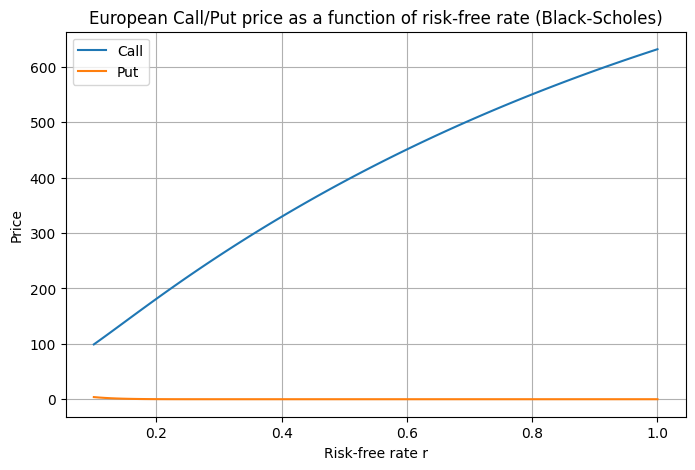

In [8]:
r = np.linspace(0.1, 1, 100)
S0 = 1000
T = 1
K=1000
s = .08
call_prices_risk = [b_s_call(S0, K, T, r_i, s) for r_i in r]
put_prices_risk = [b_s_put(S0, K, T, r_i, s) for r_i in r]

plt.figure(figsize=(8,5))
plt.plot(r, call_prices_risk, label="Call")
plt.plot(r, put_prices_risk, label="Put")
plt.title("European Call/Put price as a function of risk-free rate (Black-Scholes)")
plt.xlabel("Risk-free rate r")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

We conclude that **European Call price increases with the risk-free rate, whereas the European Put price decreases.**

### Options prices as a function of maturity.

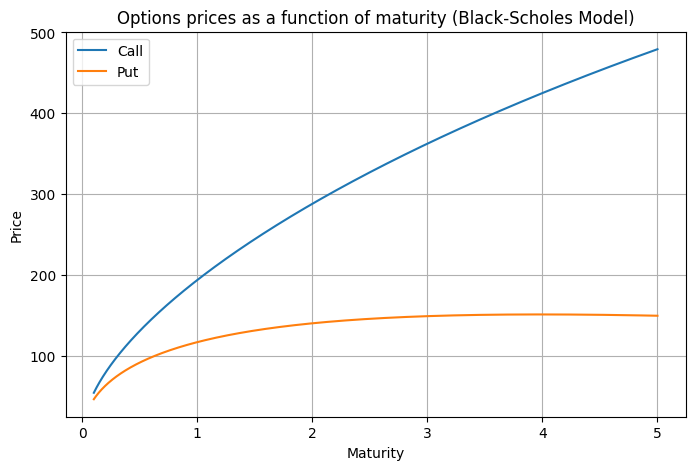

In [9]:
T= np.linspace(0.1, 5, 1000)
S0 = 1000
r = .08
s= .7
K=1000
call_prices_time = [b_s_call(S0, K, T1, r, sigma) for T1 in T ]
put_prices_time = [b_s_put(S0, K, T1, r, sigma) for T1 in T ]

plt.figure(figsize=(8,5))
plt.plot(T, call_prices_time, label="Call")
plt.title("Options prices as a function of maturity (Black-Scholes Model)")
plt.plot(T, put_prices_time, label="Put")
plt.xlabel("Maturity")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

We conclude that **European Call price increases with the maturity. The price of a European Put follows the same logic.**

# Greeks study

## 1. $\Delta$, or the sensitivity to variations of the underlying asset

The Greek $\Delta$ is defined as : $\Delta = \frac{\partial V}{\partial S}$, $V$ - option price

In our situation, the prices of european options are defined as follows :

$C_0 = e^{-rT}\mathbb{E}^{\mathbb{Q}}[(S_T-K)^+]$

and

$P_0 = e^{-rT}\mathbb{E}^{\mathbb{Q}}[(K-S_T)^+]$

Given these formulas, we deduce : 

$C_0 = S_0 \Phi(d_1) - Ke^{-r(T_t)}\Phi(d_2)$, $\Phi$ - cumulative function of $\mathcal{N}(0,1)$ (Standard Gaussian Dist.)

and $d_1 = \frac{\ln{(\frac{S_0}{K})}+(r + \frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{T-t}}$, $d_2 = \frac{\ln{(\frac{S_0}{K})}+(r - \frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{T-t}}$

After some computations, we get : $\Delta_{Call} = \Phi(d_1)$ and $\Delta_{Put} = \Phi(d_1)-1$

Text(0, 0.5, '$\\Delta')

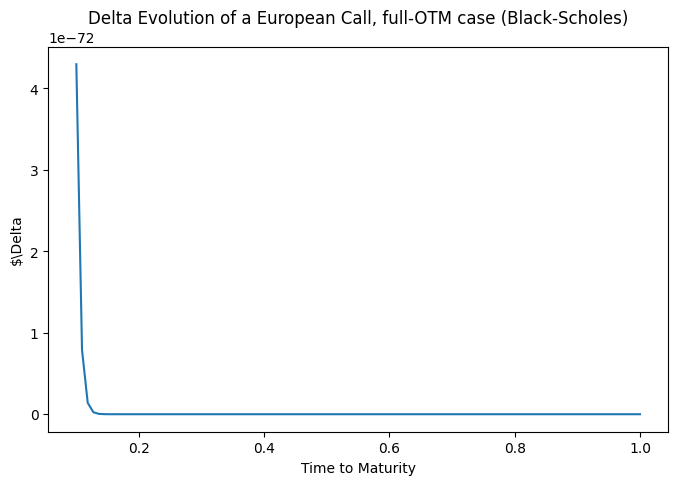

In [13]:
def call(S_, K_, T_, t, r_, s_):
    S, K = np.asarray(S_), np.asarray(K_)
    tau = np.maximum(T_ - t, 0)

    s = np.maximum(s_, 1e-16)
    st_sqrt_tau = s * np.sqrt(np.maximum(tau, 1e-16))

    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r_ + 0.5 * s**2) * tau) / st_sqrt_tau,
        0.0
    )
    d2 = d1 - st_sqrt_tau

    call_val = S * sk.norm.cdf(d1) - K * np.exp(-r_ * tau) * sk.norm.cdf(d2)
    call_val = np.where(tau == 0, np.maximum(S - K, 0), call_val)
    return call_val

def delta_call(S_, K_, T_, t, r_, s_):
    h = 0.001
    return (call(S_ + h, K_, T_, t, r_, s_) - call(S_, K_, T_, t, r_, s_)) / h

def put(S_, K_, T_, t, r_, s_):
    S, K = np.asarray(S_), np.asarray(K_)
    tau = np.maximum(T_ - t, 0)

    s = np.maximum(s_, 1e-16)
    st_sqrt_tau = s * np.sqrt(np.maximum(tau, 1e-16))

    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r_ + 0.5 * s**2) * tau) / st_sqrt_tau,
        0.0
    )
    d2 = d1 - st_sqrt_tau

    put_val = -S * sk.norm.cdf(-d1) + K * np.exp(-r_ * tau) * sk.norm.cdf(-d2)
    put_val = np.where(tau == 0, np.maximum(K - S, 0), put_val)
    return put_val
    

def delta_put(S_, K_, T_, t, r_, s_):
    h = 0.001
    return (put(S_ + h, K_, T_, t, r_, s_) - put(S_, K_, T_, t, r_, s_)) / h

# Parameters
T = 1
Td = np.linspace(0.1, 1, 100)
S0 = 1
K = 1000
sigma = 0.4
r = 0.04

# Compute delta as a function of remaining time
delta_time_call = [delta_call(S0, K, T, t, r, sigma) for t in Td]

plt.figure(figsize=(8,5))
plt.plot(Td, delta_time_call, label="Call")
plt.title("Delta Evolution of a European Call, full-OTM case (Black-Scholes)")
plt.xlabel("Time to Maturity")
plt.ylabel(r'$\Delta')


**We conclude that for the full-OTM case, $\Delta_{Call}$  decreases as the maturity approaches. Thus, the price of a European Call beacomes less sensitive to the price of an underlying asset as the maturity approaches. Moreaover, since $\Delta$ is non-negative, the price of a European Call must follow the same dynamics as the price of its underlying assets.**

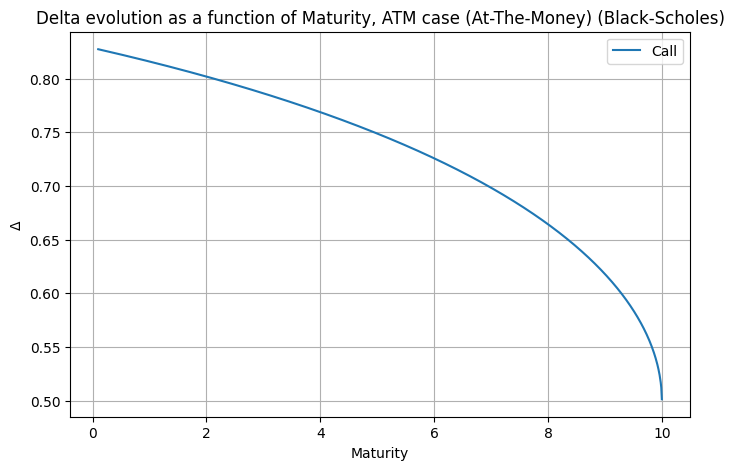

In [93]:
T=10
Td= np.linspace(0.1,9.9999, 1000)
S0=1000
K=1000
sigma = .4
r = .04
delta_time_call=[delta_call(S0, K,T, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, delta_time_call, label="Call")
plt.title(f"Delta evolution as a function of Maturity, ATM case (At-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r"$\Delta$")
plt.grid(True)
plt.legend()
plt.show()

We deduce that **when $S_0 \approx K$, $\Delta_{Call}$ decreases until 0.5 as the maturity is approached.**

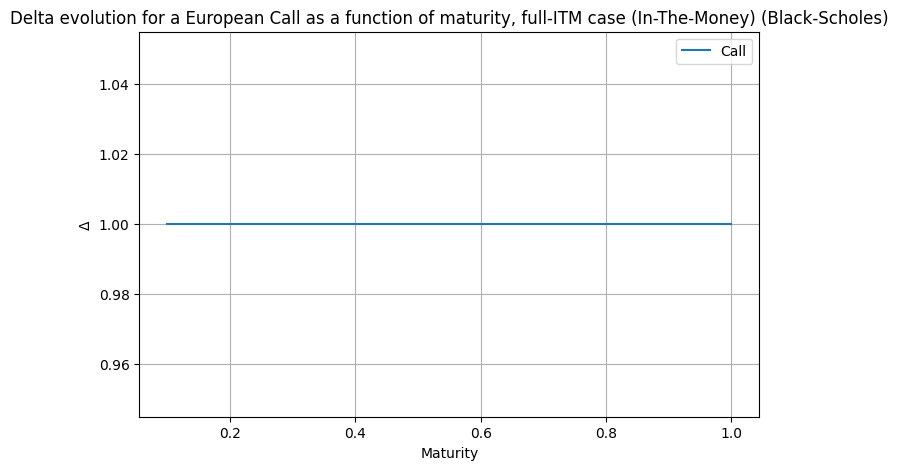

In [92]:
T=1
Td= np.linspace(0.1, 1, 1000)
S0=1000
K=1
sigma = .4
r = .04
delta_time_call=[delta_call(S0, K,T, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, delta_time_call, label="Call")
plt.title(f"Delta evolution for a European Call as a function of maturity, full-ITM case (In-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r"$\Delta$")
plt.grid(True)
plt.legend()
plt.show()

We conclude that **$\Delta_{Call}$ in the full-ITM case ($S_0 >> K$) remains unchanged**

In all three cases (full-ITM, full-OTM, ATM) : 

> Call Price follows the same dynamics as its underlying asset, becoming null as the maturity approaches.

## $\Delta$ of a Put

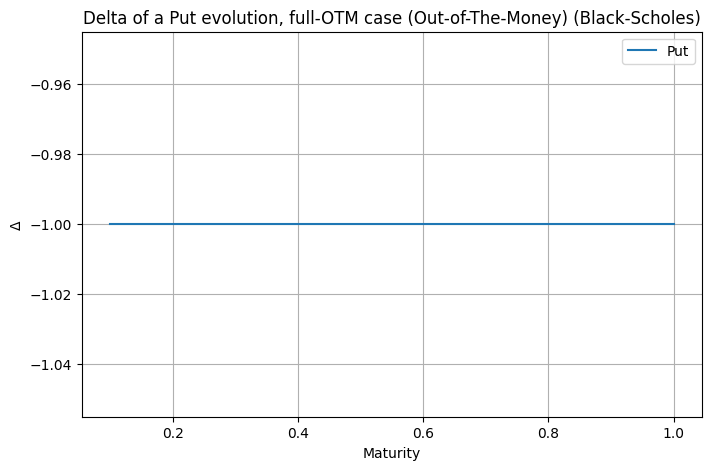

In [91]:
Td= np.linspace(0.1, 1, 1000)
T=1
S0=1
K=1000
sigma = .4
r = .04
delta_time_put=[delta_put(S0, K,T,  t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, delta_time_put, label="Put")
plt.title(f"Delta of a Put evolution, full-OTM case (Out-of-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r"$\Delta$")
plt.grid(True)
plt.legend()
plt.show()

We conclude that **$\Delta_{Put}$ remains negative, hardly changing** 

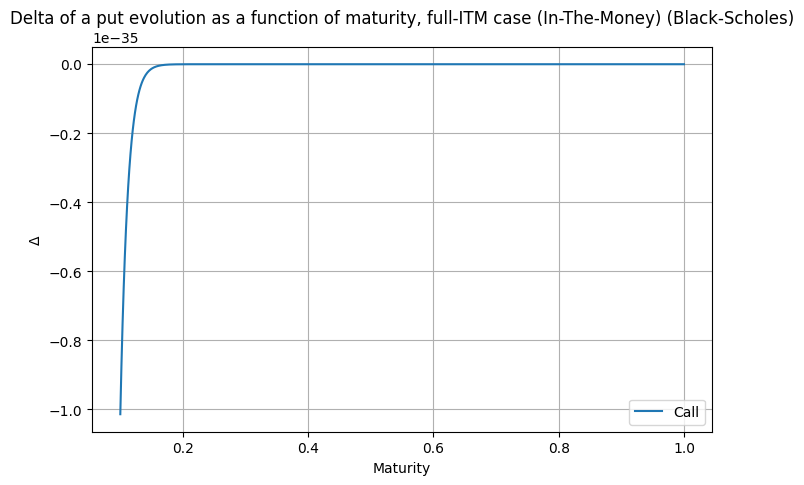

In [90]:
T=1
Td= np.linspace(0.1, 1, 1000)
S0=10000
K=100
sigma = .4
r = .04
delta_time_put=[delta_put(S0, K, T, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, delta_time_put, label="Call")
plt.title(f"Delta of a put evolution as a function of maturity, full-ITM case (In-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r"$\Delta$")
plt.grid(True)
plt.legend()
plt.show()

It can be seen that **$\Delta_{Put}$ tends to be null as the maturity time approaches to the maturity** 

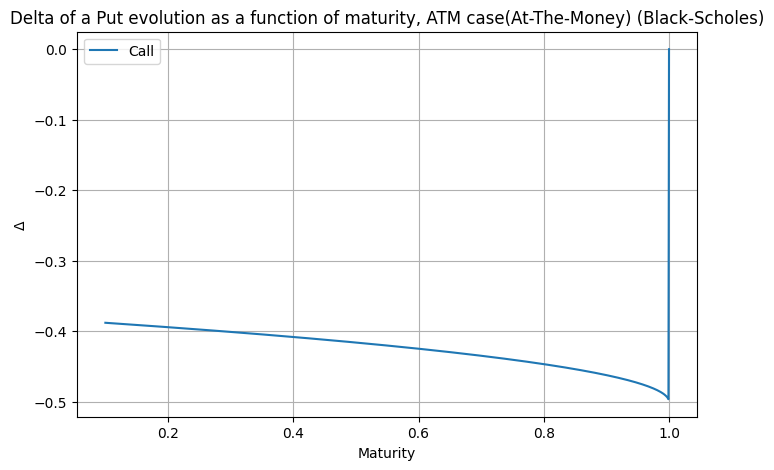

In [88]:
Td= np.linspace(0.1, 1, 1000)
T=1
S0=1000
K=1000
sigma = .4
r = .04
delta_time_put=[delta_put(S0, K, T, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, delta_time_put, label="Call")
plt.title(f"Delta of a Put evolution as a function of maturity, ATM case(At-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r"$\Delta$")
plt.grid(True)
plt.legend()
plt.show()

We conclude that **$\Delta_{Put}$ tends to be constant (equal to -0.5) as the time approaches to the maturity** 

> In each of these 3 cases, the price of a European Put follows the inverse dynamics of its underlying asset ($\Delta$ < 0)

# 2. Vega ($\nu$) -  the sensitivity of an option price to volatility

The Greek $\nu$ is defined as : $\nu$ = $\frac{\partial V}{\partial \sigma}$, $V$ - option price

Computing its analytical expression, we get :

$\nu(t)$ = $S_t$ $\phi(d_1)\sqrt{T-t}$

**$\nu$ computation shows that this Greek is the samefor a European Put or a European Call**

In [84]:
def vega(S_, K_, T_,t, r_, s_):
    h=0.001
    return (call(S_,K_, T_,t, r_, s_+h ) - call(S_, K_, T_,t, r_, s_))/h


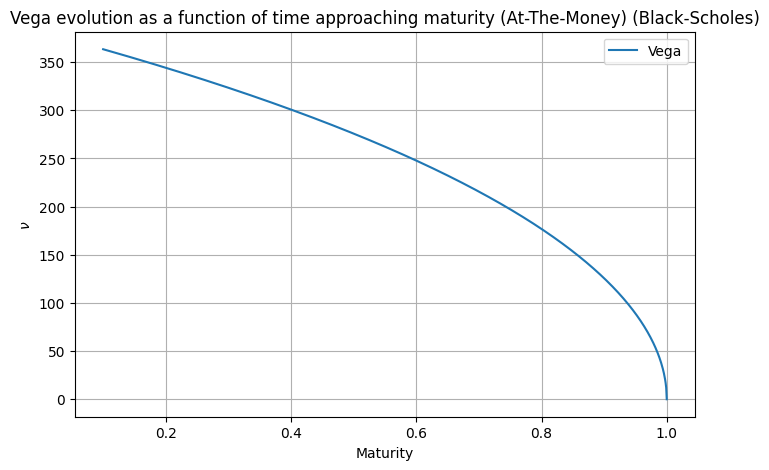

In [87]:
T=1
Td= np.linspace(0.1, 1, 1000)
S0=1000
K=1000
sigma = .4
r = .04
vega_time=[vega(S0, K, T, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, vega_time, label="Vega")
plt.title(f"Vega evolution as a function of time approaching maturity (At-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r'$\nu$')
plt.grid(True)
plt.legend()
plt.show()

**We deduce that $\nu$ approaches 0 as our time stamp approaches maturity**. It is logical, since the option price becomes less and less sensitive to the volatility as the exercice time approaches.

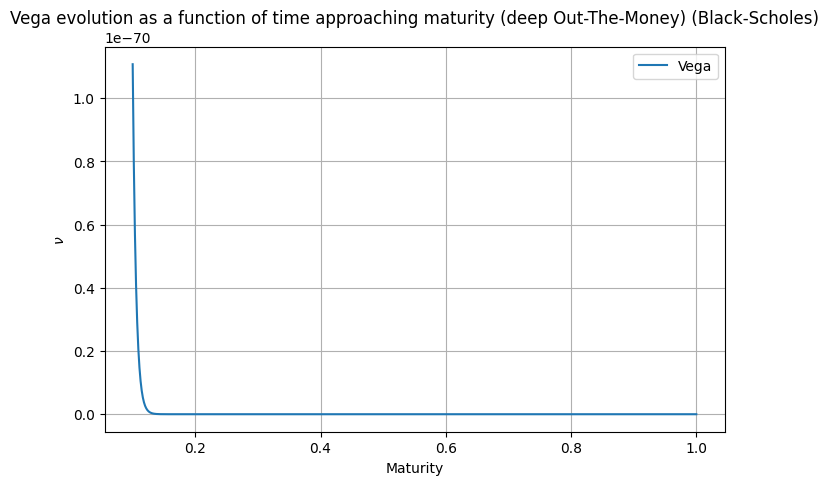

In [95]:
T=1
Td= np.linspace(0.1, 1, 1000)
S0=1
K=1000
sigma = .4
r = .04
vega_time=[vega(S0, K, T, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, vega_time, label="Vega")
plt.title(f"Vega evolution as a function of time approaching maturity (deep Out-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r'$\nu$')
plt.grid(True)
plt.legend()
plt.show()

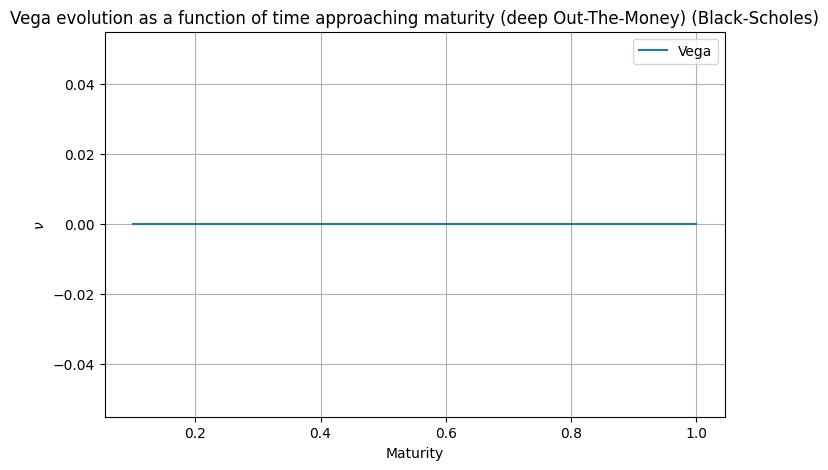

In [96]:
T=1
Td= np.linspace(0.1, 1, 1000)
S0=1000
K=1
sigma = .4
r = .04
vega_time=[vega(S0, K, T, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, vega_time, label="Vega")
plt.title(f"Vega evolution as a function of time approaching maturity (deep Out-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r'$\nu$')
plt.grid(True)
plt.legend()
plt.show()

> In all three cases, we conclude that $\nu$ tends to be null as the maturity approaches. That explains the fact, that the option price becomes insensitive to the volatility of the Market.

## 3. Theta ($\Theta$) - the sensitivity of Options Prices to time (time decay)

Given the definition of the Greek $\Theta = \frac{\partial V}{\partial t}$, $V$- option price, the analytical expression can be derived : 

$\Theta_{Call} = -\frac{S\phi(d_1)\sigma}{2\sqrt{T-t}}-rKe^{-r(T-t)}\Phi(d_2)$

$\Theta_{Put} = -\frac{S\phi(d_1)\sigma}{2\sqrt{T-t}}+rKe^{-r(T-t)}\Phi(-d_2)$

In [97]:
def theta(S_, K_, T_,t, r_, s_):
    h=0.001
    return (call(S_,K_, T_,t+h, r_, s_ ) - call(S_, K_, T_,t, r_, s_))/h

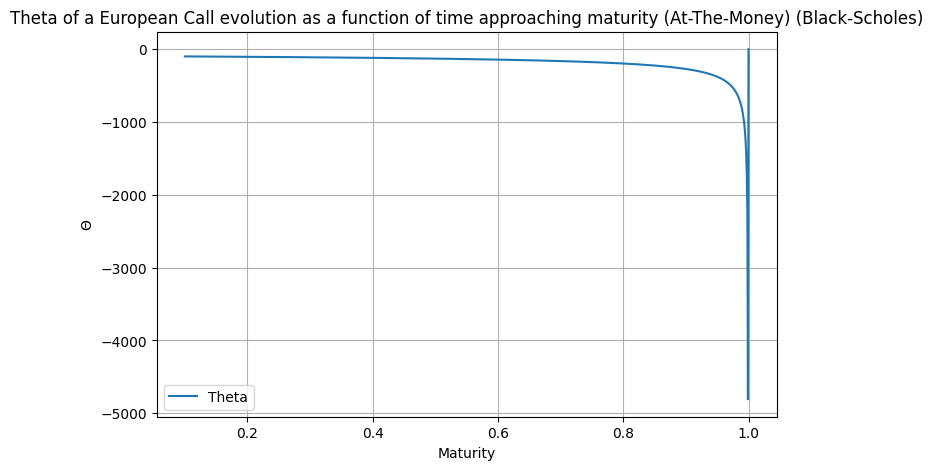

In [104]:
T=1
Td= np.linspace(0.1, 1, 1000)
S0=1000
K=1000
sigma = .4
r = .04
vega_time=[theta(S0, K, T, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, vega_time, label="Theta")
plt.title(f"Theta of a European Call evolution as a function of time approaching maturity (At-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r'$\Theta$')
plt.grid(True)
plt.legend()
plt.show()

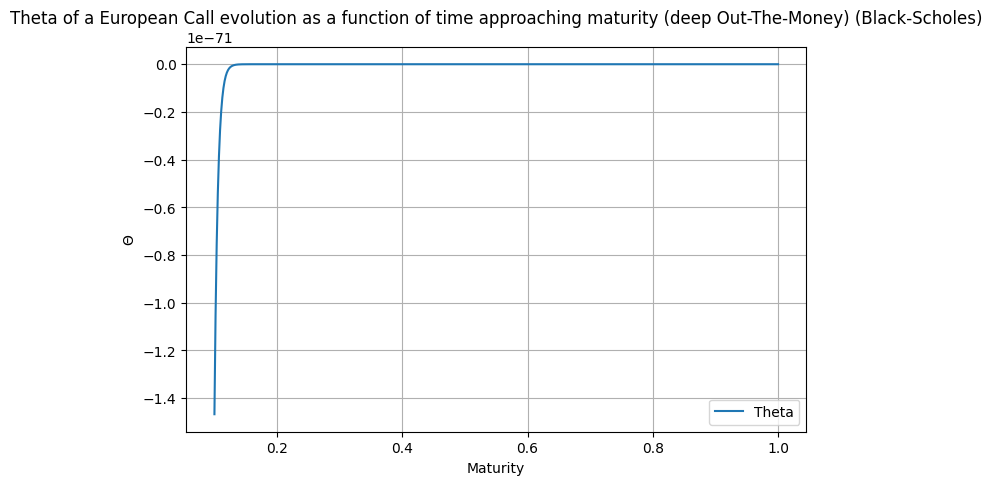

In [105]:
T=1
Td= np.linspace(0.1, 1, 1000)
S0=1
K=1000
sigma = .4
r = .04
vega_time=[theta(S0, K, T, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, vega_time, label="Theta")
plt.title(f"Theta of a European Call evolution as a function of time approaching maturity (deep Out-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r'$\Theta$')
plt.grid(True)
plt.legend()
plt.show()

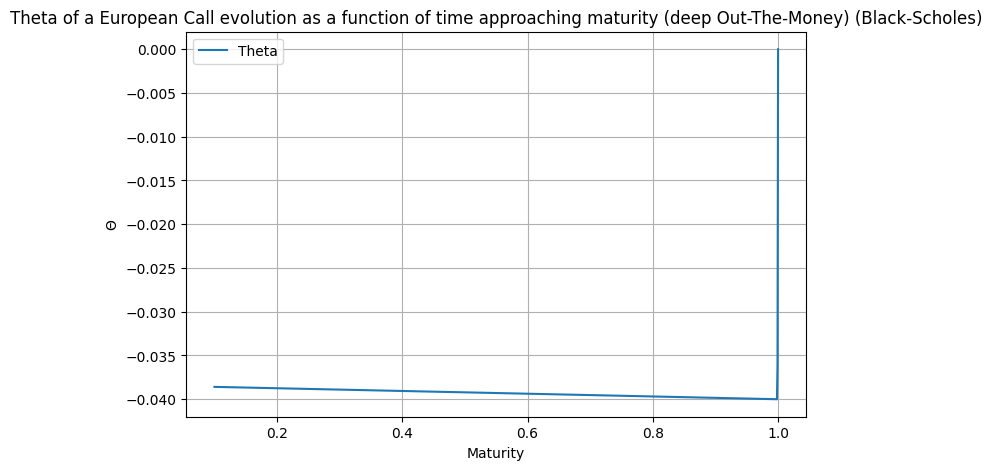

In [107]:
T=1
Td= np.linspace(0.1, 1, 1000)
S0=1000
K=1
sigma = .4
r = .04
vega_time=[theta(S0, K, T, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(Td, vega_time, label="Theta")
plt.title(f"Theta of a European Call evolution as a function of time approaching maturity (deep Out-The-Money) (Black-Scholes)")
plt.xlabel("Maturity")
plt.ylabel(r'$\Theta$')
plt.grid(True)
plt.legend()
plt.show()

We conclude that **$\Theta$ is always negative for a European call, meaning that it loses its price as the maturity approaches. The worst case ($\Theta \rightarrow -\infty$ ) is the ATM case.**